# Создание предсказательной системы стоимости ценных бумаг с использованием нейронных сетей


S&P 500 https://www.kaggle.com/datasets/camnugent/sandp500
Данный датасет предоставляет исторические данные о ценах акций на рынке за последние 5 лет для компаний, входящих в индекс S&P 500. Данные представлены в формате .csv и охватывают такие параметры, как дата, открытие, максимальная и минимальная цены, объем торгов и имена компаний

In [ ]:
!pip install -q yfinance

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# данные из yahoo
import yfinance as yf
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
yf.pdr_override()

# игнорирование лишних сообщений об ошибках
import warnings
warnings.filterwarnings('ignore')

# Обзор датасета

Начальный анализ и загрузка данных

In [ ]:
# акции, которые будут использоваться
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-04-24,179.940002,180.320007,176.179993,176.589996,176.589996,34185100,AMAZON
2024-04-25,169.679993,173.919998,166.320007,173.669998,173.669998,49249400,AMAZON
2024-04-26,177.800003,180.820007,176.130005,179.619995,179.619995,43919800,AMAZON
2024-04-29,182.750000,183.529999,179.389999,180.960007,180.960007,54063900,AMAZON
2024-04-30,181.089996,182.990005,174.800003,175.000000,175.000000,94639800,AMAZON
2024-05-01,181.639999,185.149994,176.559998,179.000000,179.000000,94645100,AMAZON
2024-05-02,180.850006,185.100006,179.910004,184.720001,184.720001,54303500,AMAZON
2024-05-03,186.990005,187.869995,185.419998,186.210007,186.210007,39172000,AMAZON
2024-05-06,186.279999,188.750000,184.800003,188.699997,188.699997,34653900,AMAZON


Просматривая содержимое наших данных, мы видим, что данные являются числовыми, а дата является индексом данных. Также обратим внимание, что в записях отсутствуют выходные дни.

In [ ]:
# общая статистика
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,181.355556,182.818254,179.973690,181.428818,181.060407,5.816545e+07
std,8.586440,8.434531,8.555809,8.533683,8.473554,1.866484e+07
min,165.350006,166.399994,164.080002,165.000000,165.000000,2.404830e+07
25%,173.747494,175.375000,172.417500,173.750000,173.494946,4.674302e+07
50%,181.065002,182.434998,179.144997,180.955002,180.449684,5.368500e+07
75%,189.277496,189.990005,187.652500,189.317501,188.879902,6.465378e+07
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.632241e+08


В данных только 255 записи за 1 год, из за отсутсвия выходных

In [ ]:
# General info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2023-05-08 to 2024-05-07
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          252 non-null    float64
 1   High          252 non-null    float64
 2   Low           252 non-null    float64
 3   Close         252 non-null    float64
 4   Adj Close     252 non-null    float64
 5   Volume        252 non-null    int64  
 6   company_name  252 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.8+ KB


Цена закрытия - это последняя цена, по которой акция торгуется в течение обычного торгового дня. Цена закрытия акции - это стандартный ориентир, используемый инвесторами для отслеживания ее динамики с течением времени.

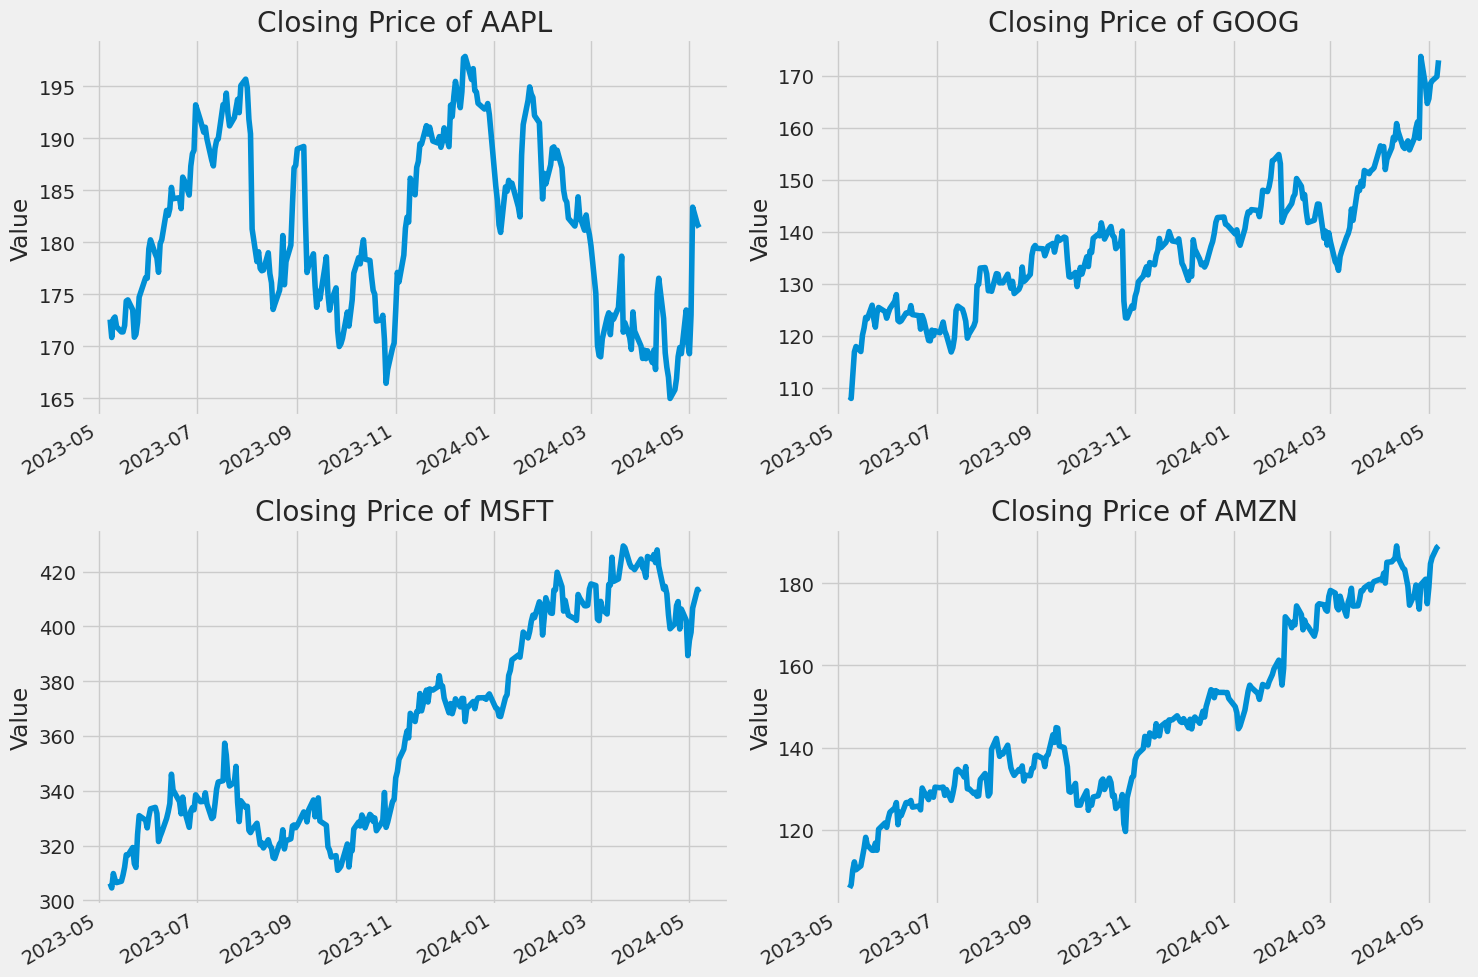

In [ ]:
# посмотрим на изменение цены закрытия
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Value')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

Объем - это количество актива или ценной бумаги, которое переходит из рук в руки в течение некоторого периода времени, часто в течение дня. Например, объем торгов акциями может относиться к количеству акций, проданных с момента открытия и закрытия акции. Объем торгов и его изменения с течением времени являются важными исходными данными для технических трейдеров.

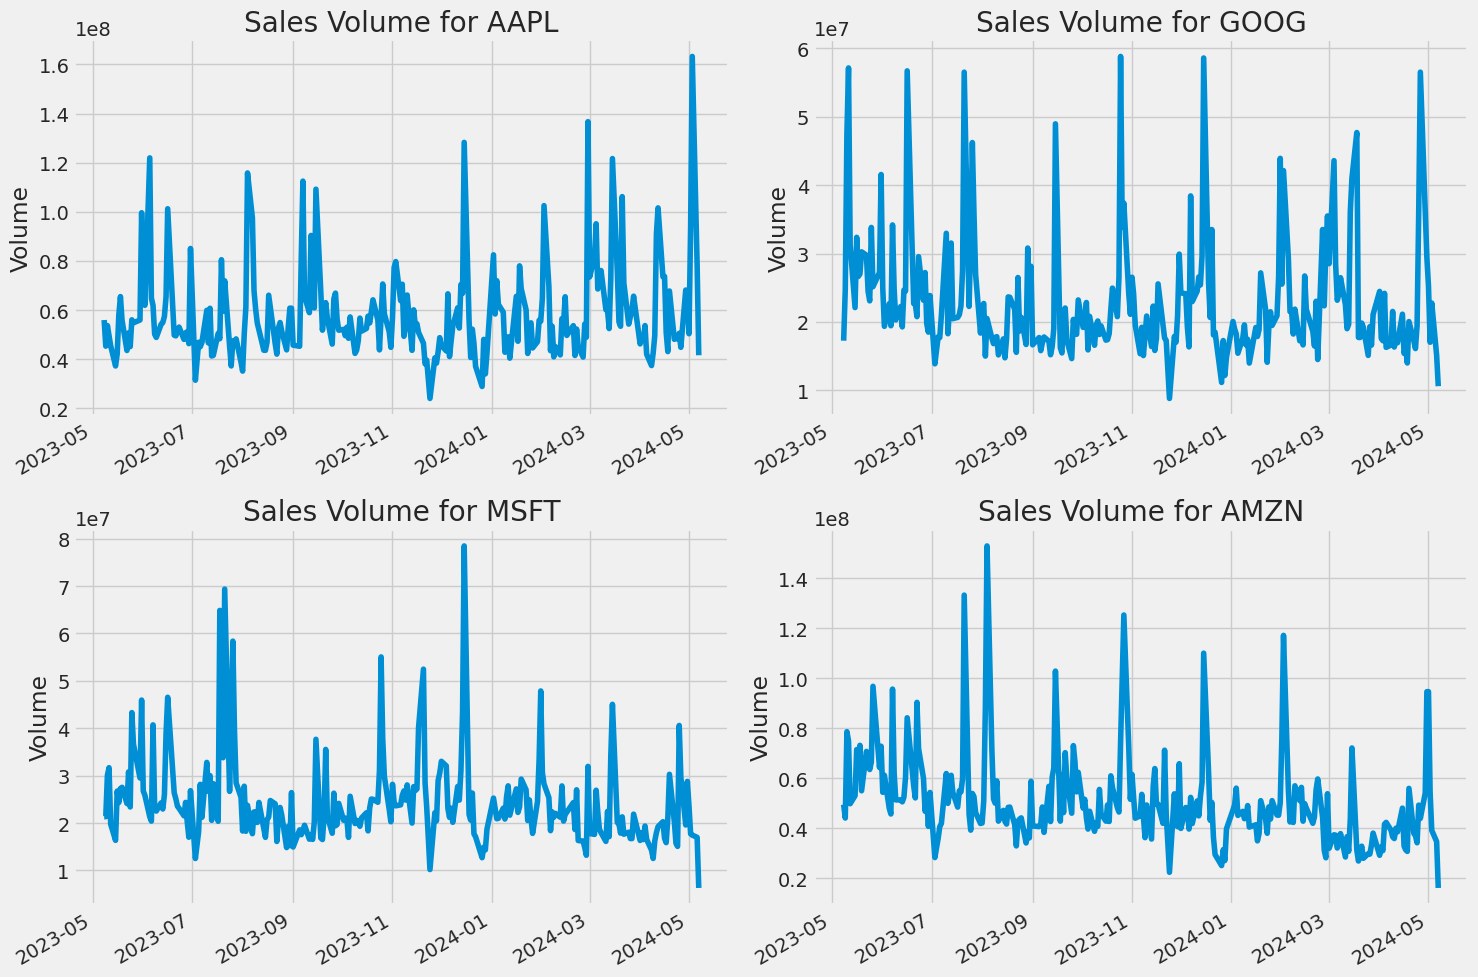

In [ ]:
# посмотрим на количество сделок на каждый день по ценным бумагам
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")

plt.tight_layout()

Теперь, когда мы ознакомились с визуализацией цены закрытия и объема торгов за каждый день, давайте продолжим и рассчитаем скользящую среднюю для акции

# Расчет скользящего среднего

Скользящая средняя (MA) - это простой инструмент технического анализа, который сглаживает ценовые данные, создавая постоянно обновляемую среднюю цену.

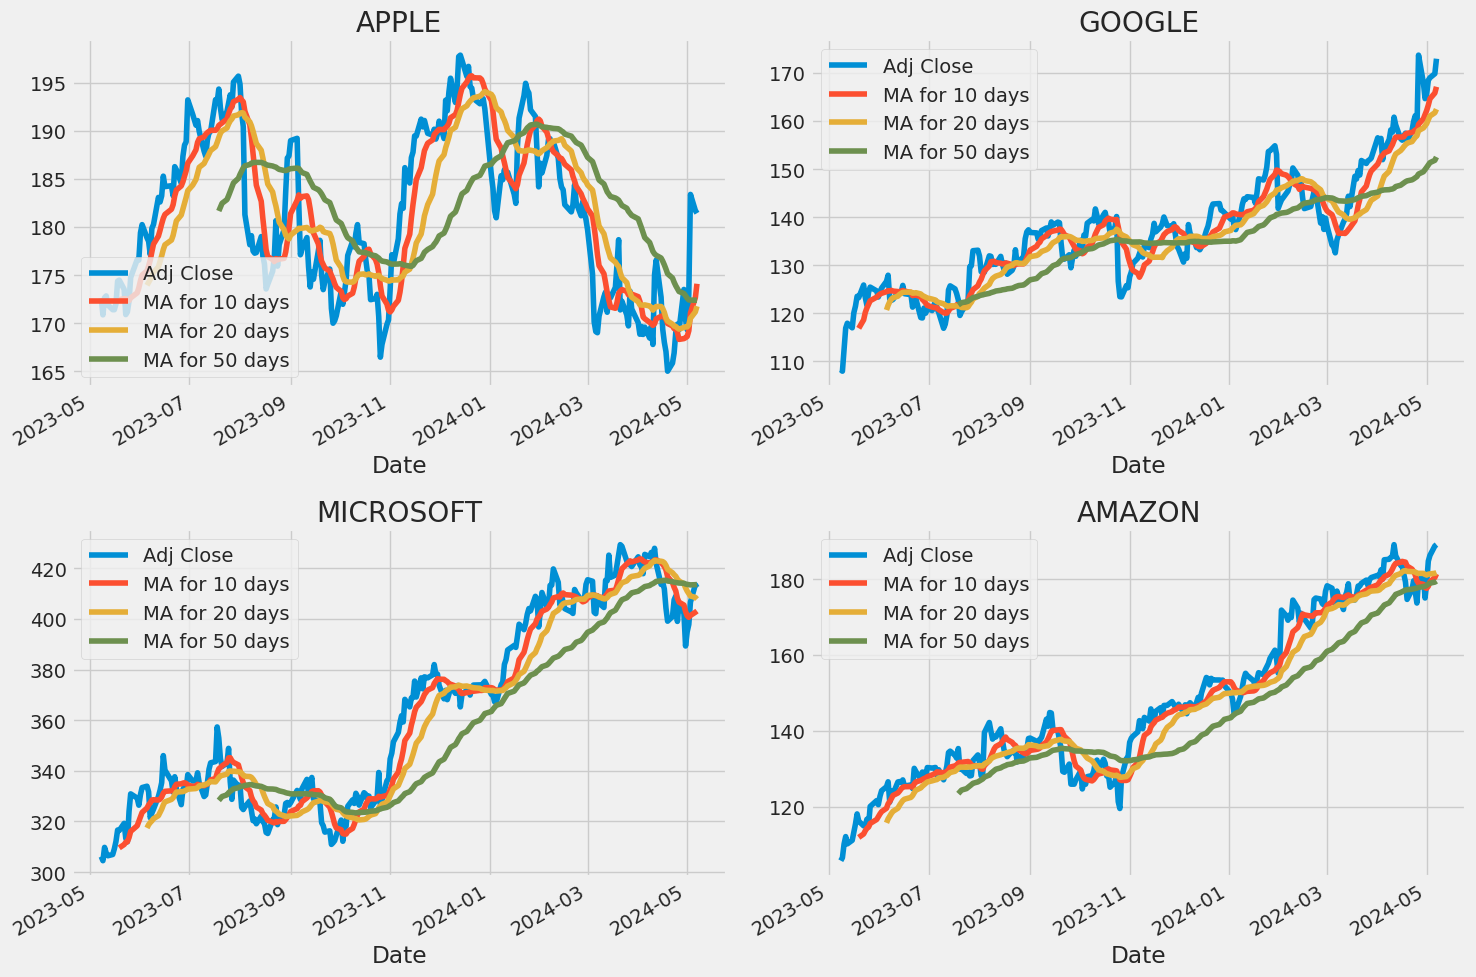

In [ ]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

На графике мы видим, что наилучшие значения для измерения скользящей средней - это 10 и 20 дней, так как они лучше всего показювыют общий трен, включая локальные изменения

# Средняя ежедневная доходность акций

Для расчета доходности, необходимо закладывать риски, связанные с акциями. Для этого нужно изучить ежедневные изменения стоимости акций, а не только их абсолютную стоимость.

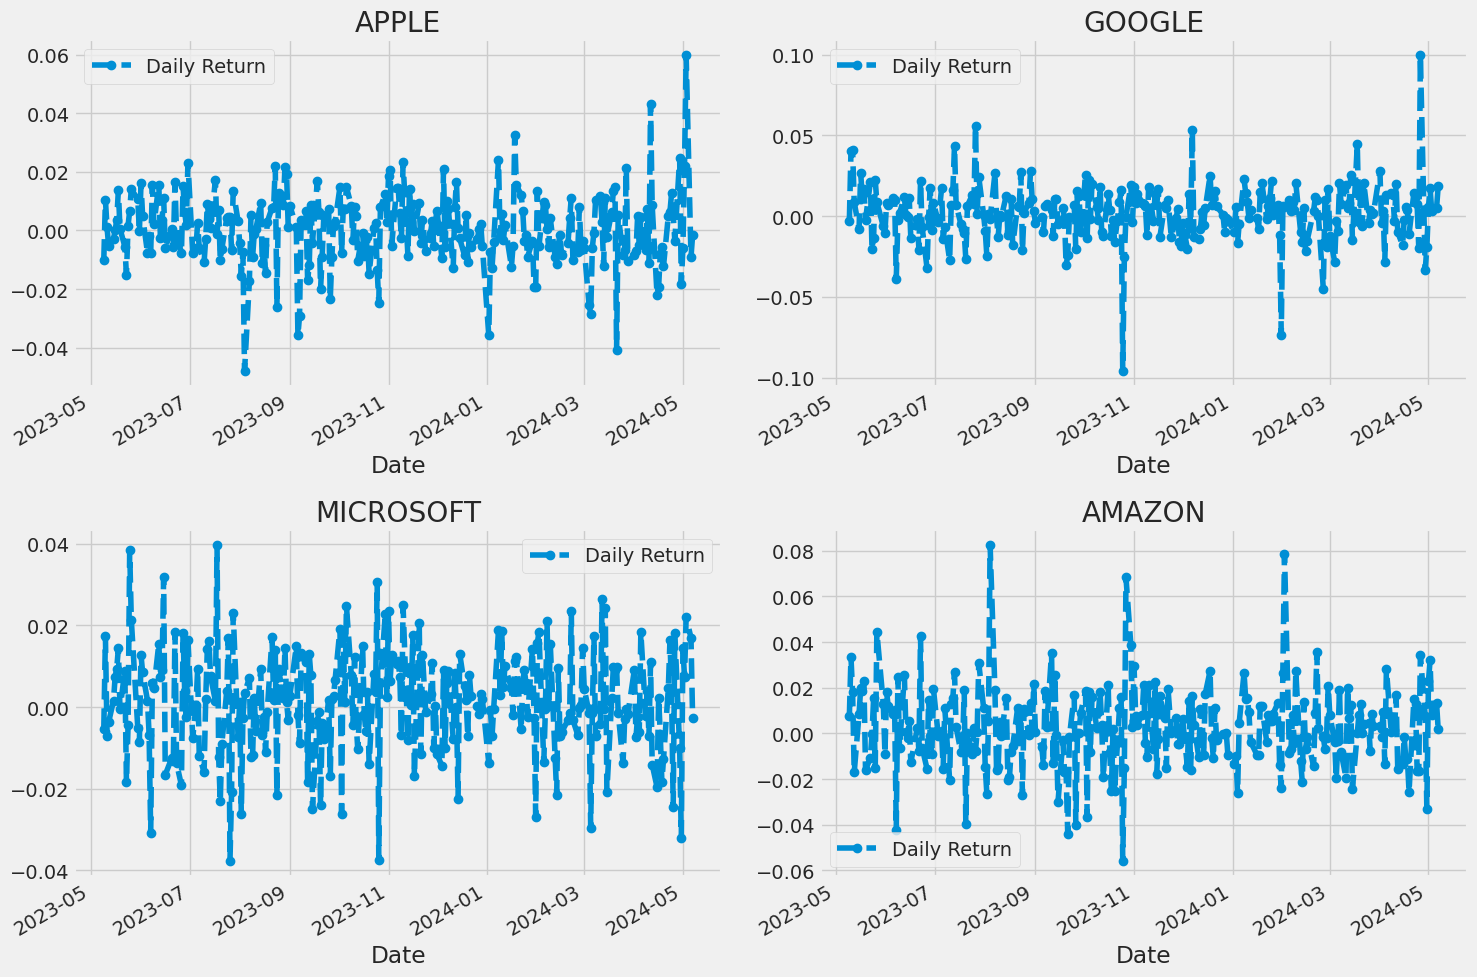

In [ ]:
# pct_change для отслеживания изменений за день
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# выведем дневную доходность акций
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

Рассмотрим среднюю дневную доходность в целом, используя гистограмму

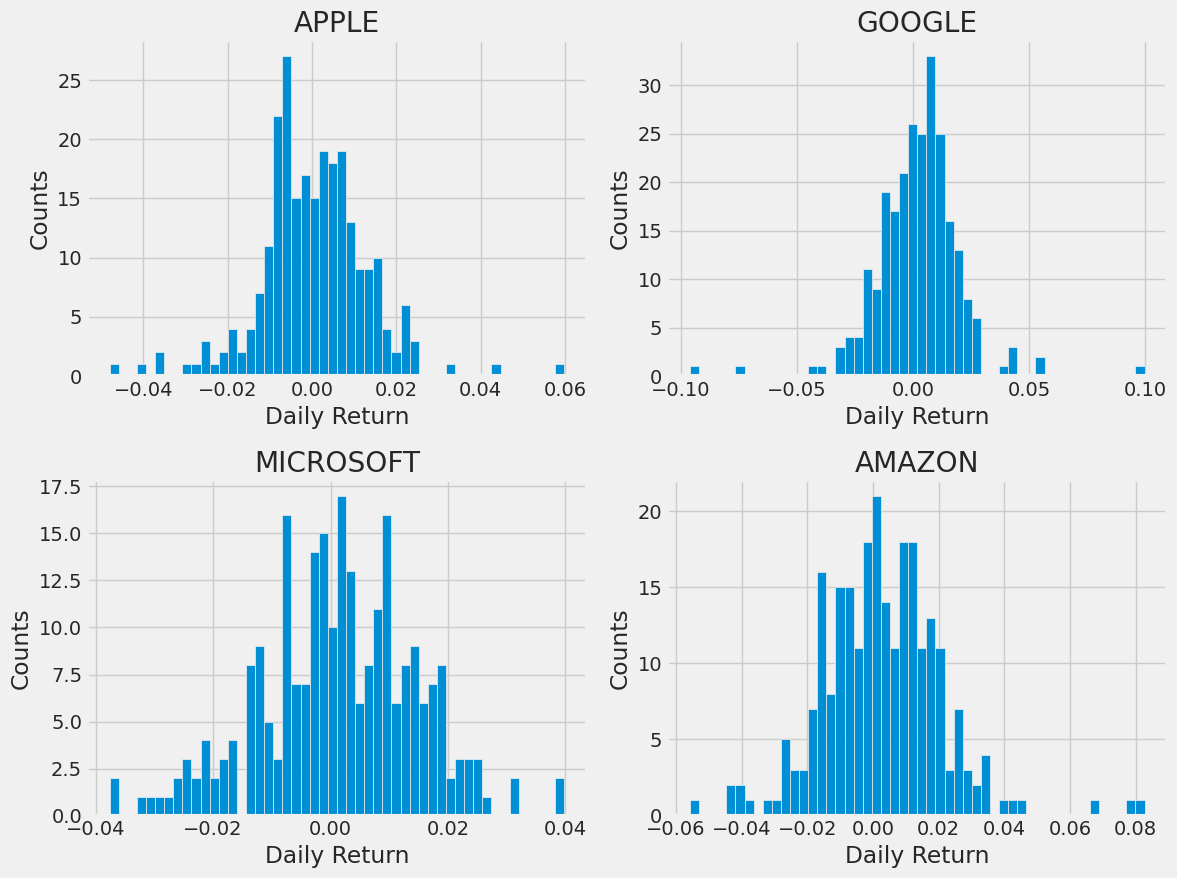

In [ ]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')

plt.tight_layout()

# Корреляционный анализ

Корреляция — это статистический показатель, который измеряет степень, в которой две переменные изменяются по отношению друг к другу, значение которого должно находиться в диапазоне от -1 до +1

In [ ]:
closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-05-08,NaN,NaN,NaN,NaN
2023-05-09,-0.009971,0.007465,-0.002772,-0.005346
2023-05-10,0.010421,0.033483,0.040207,0.017296
2023-05-11,0.001095,0.018060,0.041147,-0.007044
2023-05-12,-0.005418,-0.017115,0.008725,-0.003676


Теперь можно сравнить ежедневную процентную доходность двух акций, чтобы проверить, насколько они взаимосвязаны. Сначала сравним акцию с самой собой

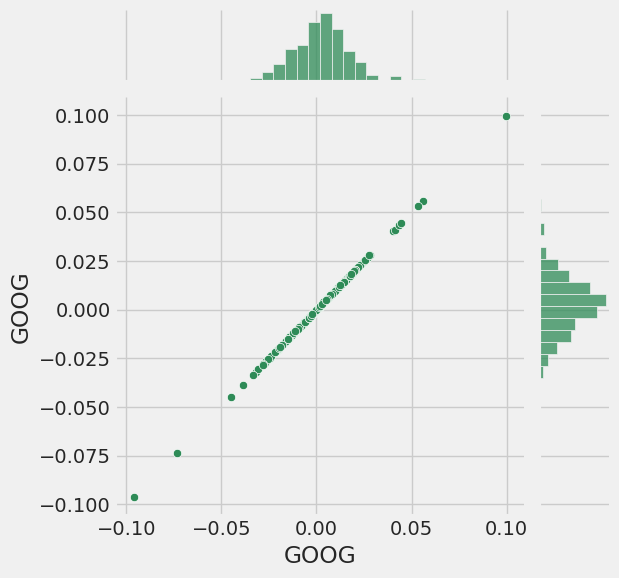

In [ ]:
# сравнение Google саму с собой. должна быть идеальная линейная связь
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

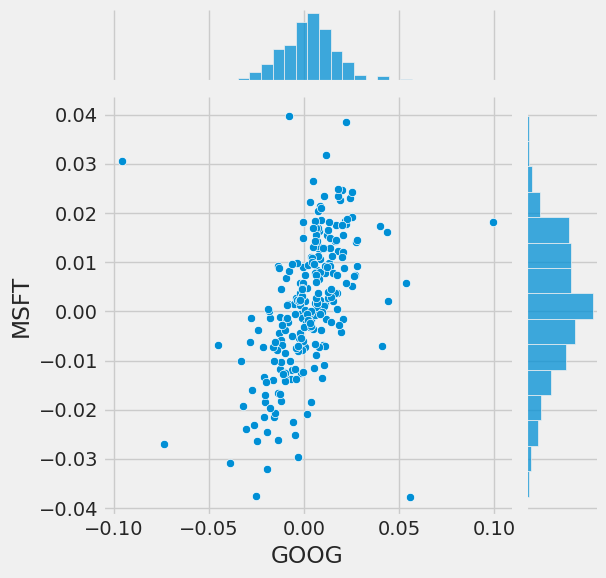

In [ ]:
# сравнение Google и Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

Можно видеть, что если две акции идеально (и положительно) коррелируют друг с другом, то между их ежедневными доходностями должна быть линейная зависимость

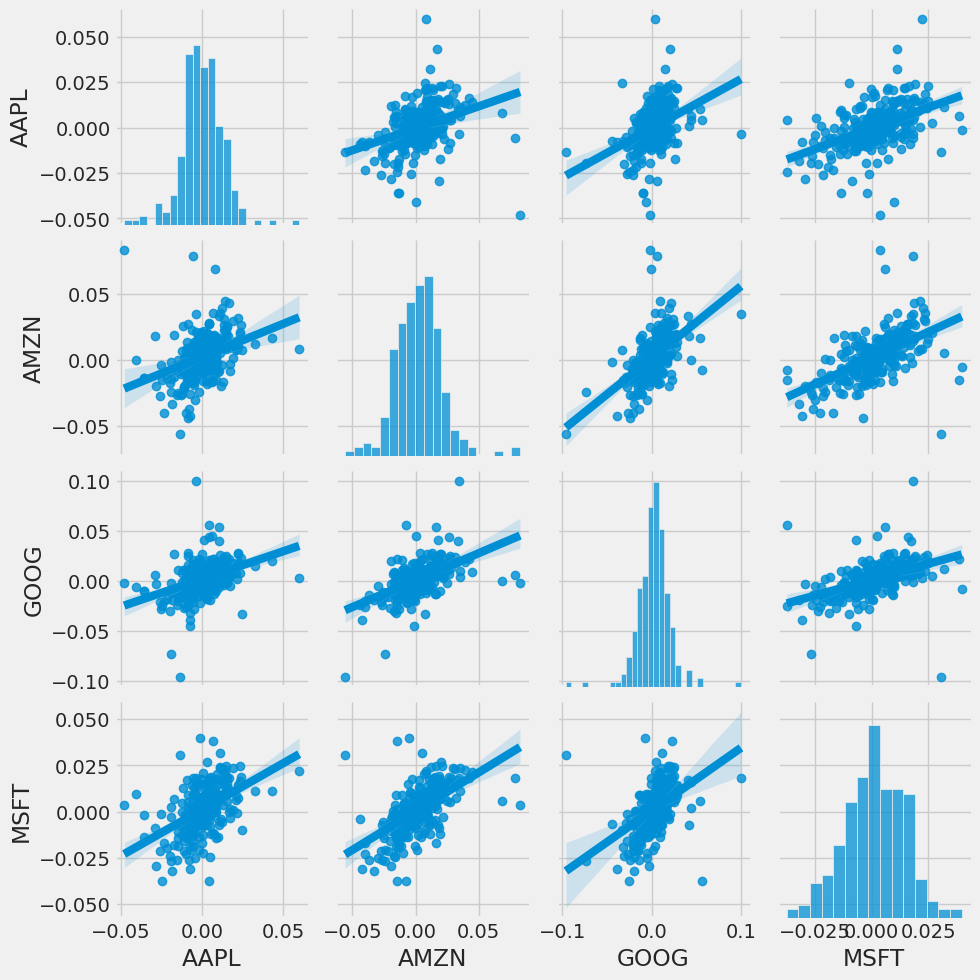

In [ ]:
sns.pairplot(tech_rets, kind='reg')

Это все взаимосвязи по ежедневной доходности между всеми акциями. Можно заметить корреляцию между ежедневной доходностью Google и Amazon, стоит провести более детальный разбор двух этих акций

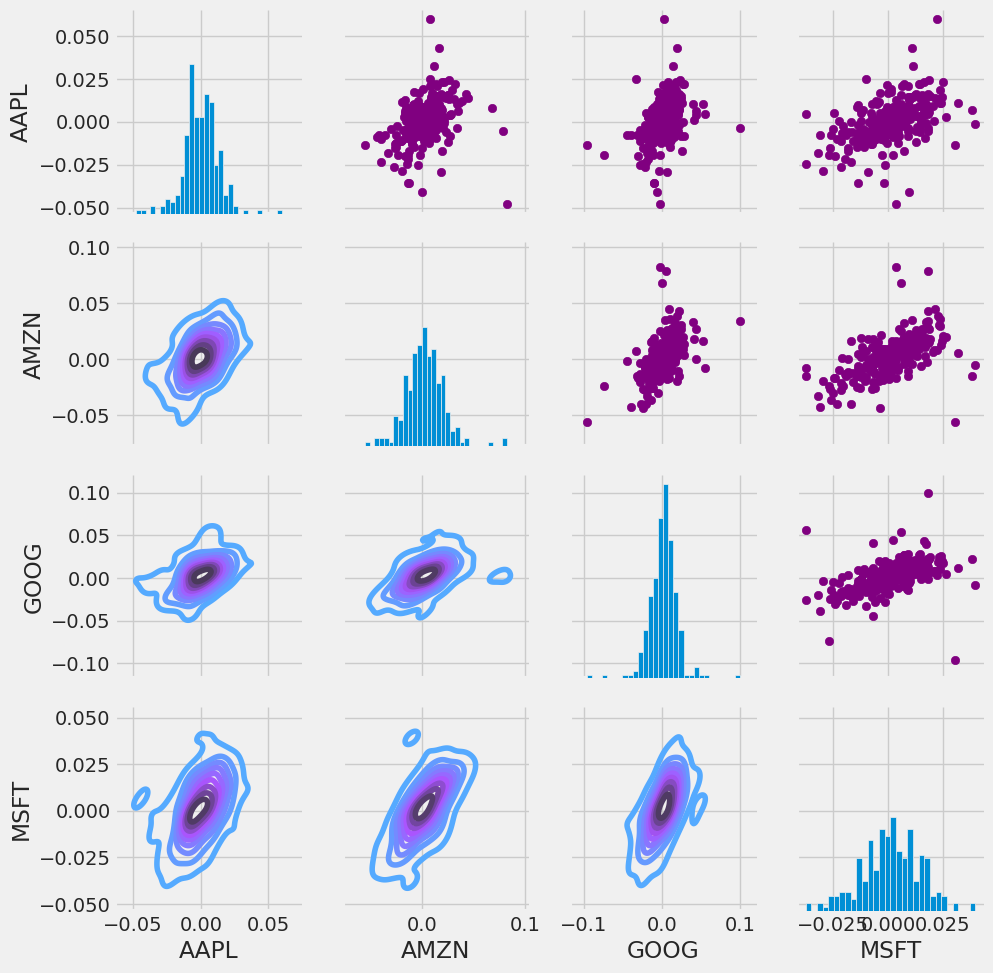

In [ ]:
return_fig = sns.PairGrid(tech_rets.dropna())
return_fig.map_upper(plt.scatter, color='purple')
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# диагональ ежедневной доходности
return_fig.map_diag(plt.hist, bins=30)

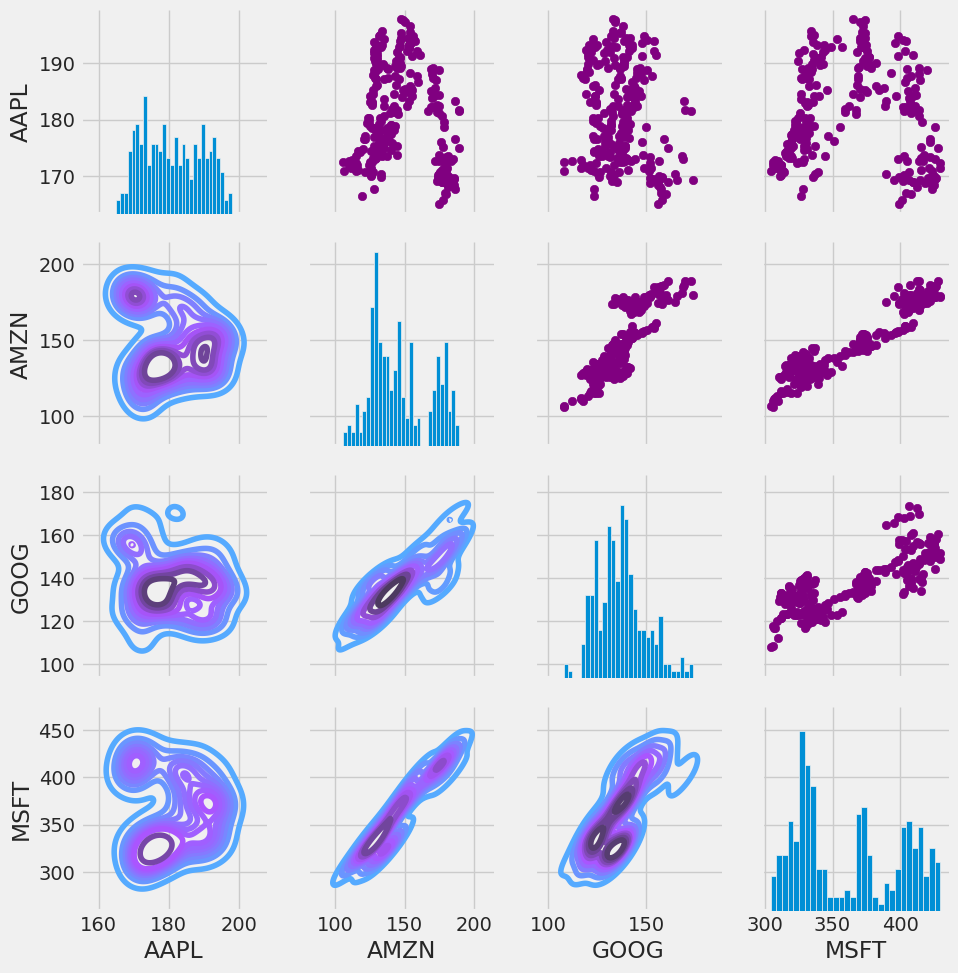

In [ ]:
# цена закрытия акций
returns_fig = sns.PairGrid(closing_df)
returns_fig.map_upper(plt.scatter,color='purple')
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

returns_fig.map_diag(plt.hist,bins=30)

График корреляции, для получения фактические числовые значения корреляции между ежедневными доходностями акций. Сравнивая цены закрытия, мы видим интересную взаимосвязь между Microsoft и Apple.

Text(0.5, 1.0, 'Корреляция цены закрытия акции')

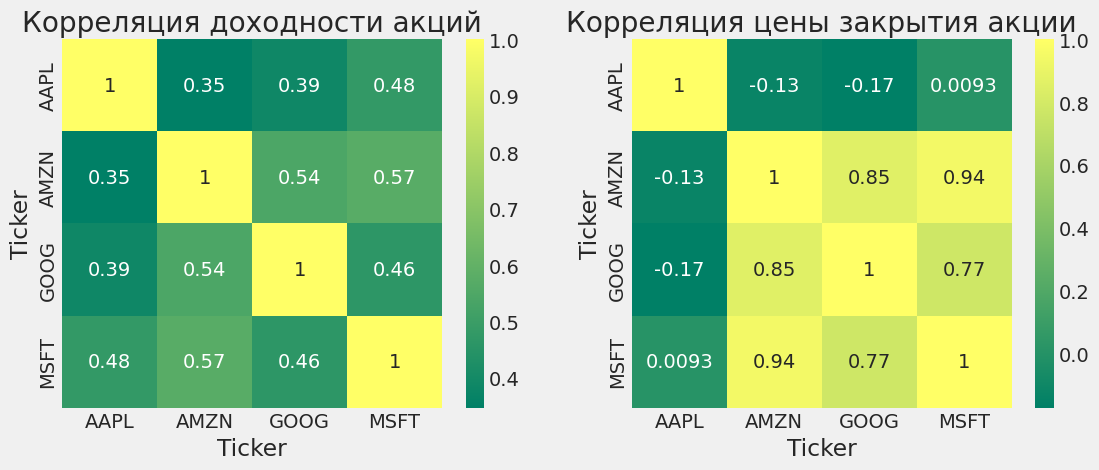

In [ ]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Корреляция доходности акций')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Корреляция цены закрытия акции')

у Microsoft и Amazon самая сильная корреляция ежедневной доходности акций. Интересно также отметить, что все технологические компании имеют положительную корреляцию


# Оценка суммы риска при инвестировании

Существует множество способов количественной оценки риска, один из самых простых способов использования собранной нами информации о ежедневной процентной доходности - это сравнение ожидаемой доходности со стандартным отклонением ежедневной доходности

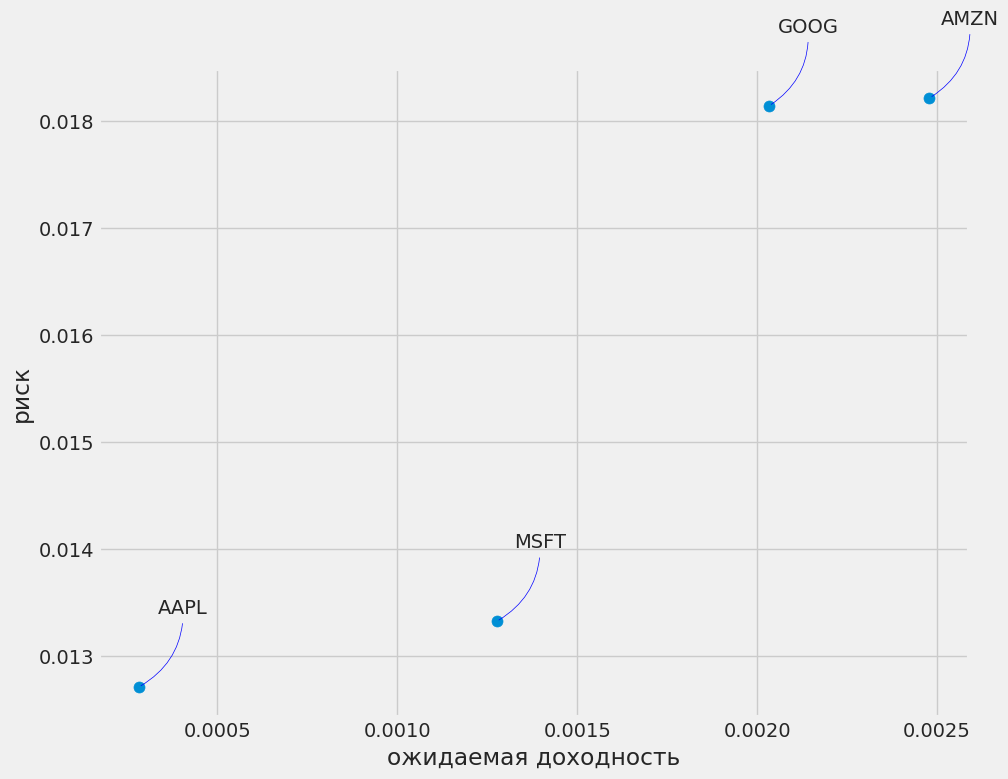

In [ ]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('ожидаемая доходность')
plt.ylabel('риск')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

# Прогнозирование цены закрытия торгов акциями APPLE

In [ ]:
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433821,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500647,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639430,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771559,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751298,394024400
...,...,...,...,...,...,...
2024-05-01,169.580002,172.710007,169.110001,169.300003,169.300003,50383100
2024-05-02,172.509995,173.419998,170.889999,173.029999,173.029999,94214900
2024-05-03,186.649994,187.000000,182.660004,183.380005,183.380005,163224100


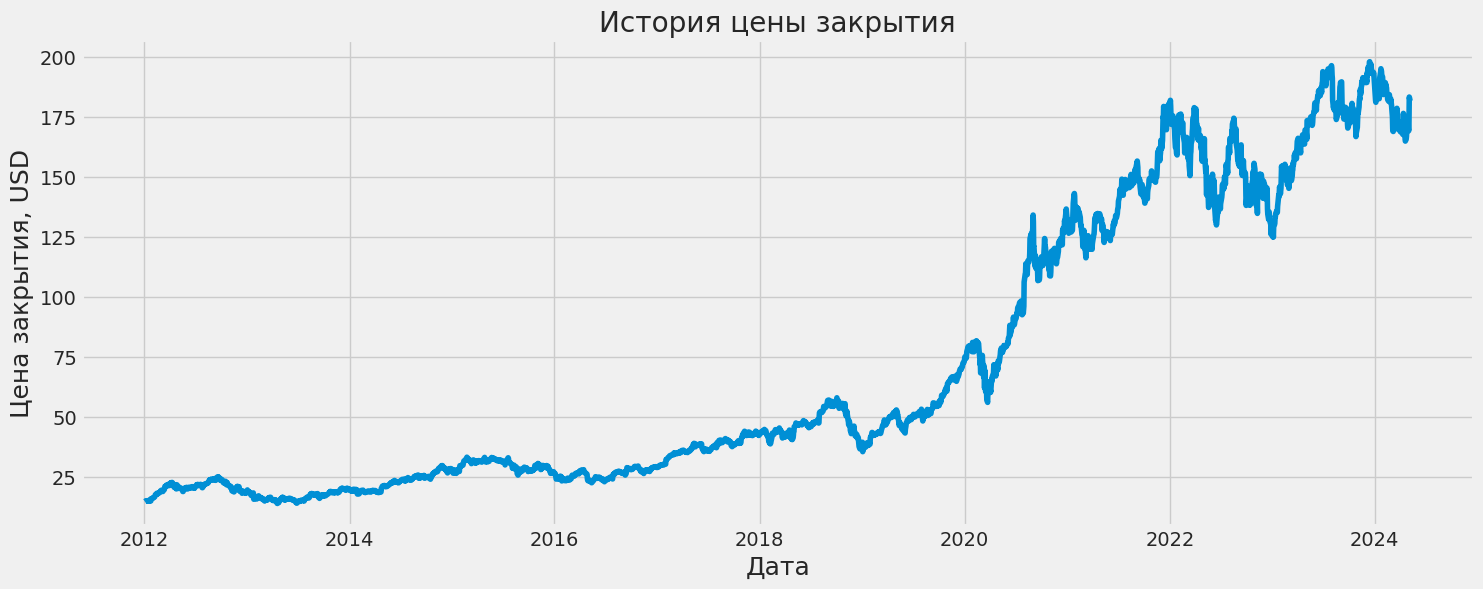

In [ ]:
plt.figure(figsize=(16,6))
plt.title('История цены закрытия')
plt.plot(df['Close'])
plt.xlabel('Дата', fontsize=18)
plt.ylabel('Цена закрытия, USD', fontsize=18)
plt.show()

In [ ]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2951

In [ ]:
# нормализация данных
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data.shape

(3106, 1)

In [ ]:
# создание обучабщего датасета
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    # if i<= 61:
    #     print(x_train)
    #     print(y_train)
    #     print()

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2891, 60, 1)

In [ ]:
# создание тестового набора данных
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [ ]:
def plot_result(data, training_data_len, predicted_values):
  '''
  строит график с реальными данными и предсказанными
  '''
  train = data[:training_data_len]
  valid = data[training_data_len:]
  valid['Predictions'] = predicted_values
  valid['Predictions'] = valid['Predictions']
  plt.figure(figsize=(16,6))
  plt.title('Предсказание стоимости акций')
  plt.xlabel('Дата', fontsize=18)
  plt.ylabel('Цена закрытия, USD', fontsize=18)
  plt.plot(train['Close'])
  plt.plot(valid[['Close', 'Predictions']])
  plt.legend(['Train', 'Val', 'Pred'], loc='upper left')
  plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def evaluate_regression_model(y_true, y_pred):
    # Вычисление среднеквадратичной ошибки
    mse = mean_squared_error(y_true, y_pred)
    # Вычисление средней абсолютной ошибки
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    # Вычисление коэффициента детерминации (R^2)
    r2 = r2_score(y_true, y_pred)

    return {'MSE': mse, 'MAE': mae, 'MAPE': mape, 'R^2': r2}

# RNN

Рекуррентные нейронные сети (RNN) представляют собой класс нейронных сетей, который эффективно обрабатывает последовательные и временные данные. Одной из ключевых особенностей RNN является их способность к учету контекста и зависимостей в последовательных данных. Это достигается за счет обратной связи, которая позволяет передавать информацию о предыдущих состояниях сети на следующие временные шаги.

Основная архитектура RNN состоит из повторяющихся блоков нейронов, которые обрабатывают входные данные по одному элементу за раз и передают свое состояние следующему блоку. Таким образом, каждый блок RNN имеет внутреннее состояние, которое обновляется с каждым новым входным элементом.

Одной из сложностей, с которой сталкиваются RNN, является проблема затухающего градиента при обучении на длинных последовательностях. Это происходит из-за того, что градиент ошибки быстро уменьшается или увеличивается при распространении обратно через множество временных шагов, что затрудняет обучение сети на длинных последовательностях.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(RNNModel, self).__init__()
        self.rnn1 = nn.RNN(input_size, hidden_size1, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size1, hidden_size2, batch_first=True)
        self.fc1 = nn.Linear(hidden_size2, 25)
        self.fc2 = nn.Linear(25, output_size)

    def forward(self, x):
        out, _ = self.rnn1(x)
        out, _ = self.rnn2(out)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

    def predict(self, x):
        with torch.no_grad():
            out, _ = self.rnn1(x)
            out, _ = self.rnn2(out)
            out = self.fc1(out[:, -1, :])
            out = self.fc2(out)
            return out

# Определение размеров входных и выходных данных
input_size = 1  # Размер входных данных
hidden_size1 = 128  # Размер скрытого слоя RNN1
hidden_size2 = 64  # Размер скрытого слоя RNN2
output_size = 1  # Размер выходных данных

# Создание модели
model = RNNModel(input_size, hidden_size1, hidden_size2, output_size)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Обучение модели
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Предсказание
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
with torch.no_grad():
    predicted_values = model.predict(X_test_tensor)
predicted_values = predicted_values*1.015

# print("Predictions:")
# print(predicted_values)


Epoch [10/100], Loss: 0.1511
Epoch [20/100], Loss: 0.0579
Epoch [30/100], Loss: 0.1641
Epoch [40/100], Loss: 0.0914
Epoch [50/100], Loss: 0.0347
Epoch [60/100], Loss: 0.0454
Epoch [70/100], Loss: 0.0227
Epoch [80/100], Loss: 0.0103
Epoch [90/100], Loss: 0.0060
Epoch [100/100], Loss: 0.0039


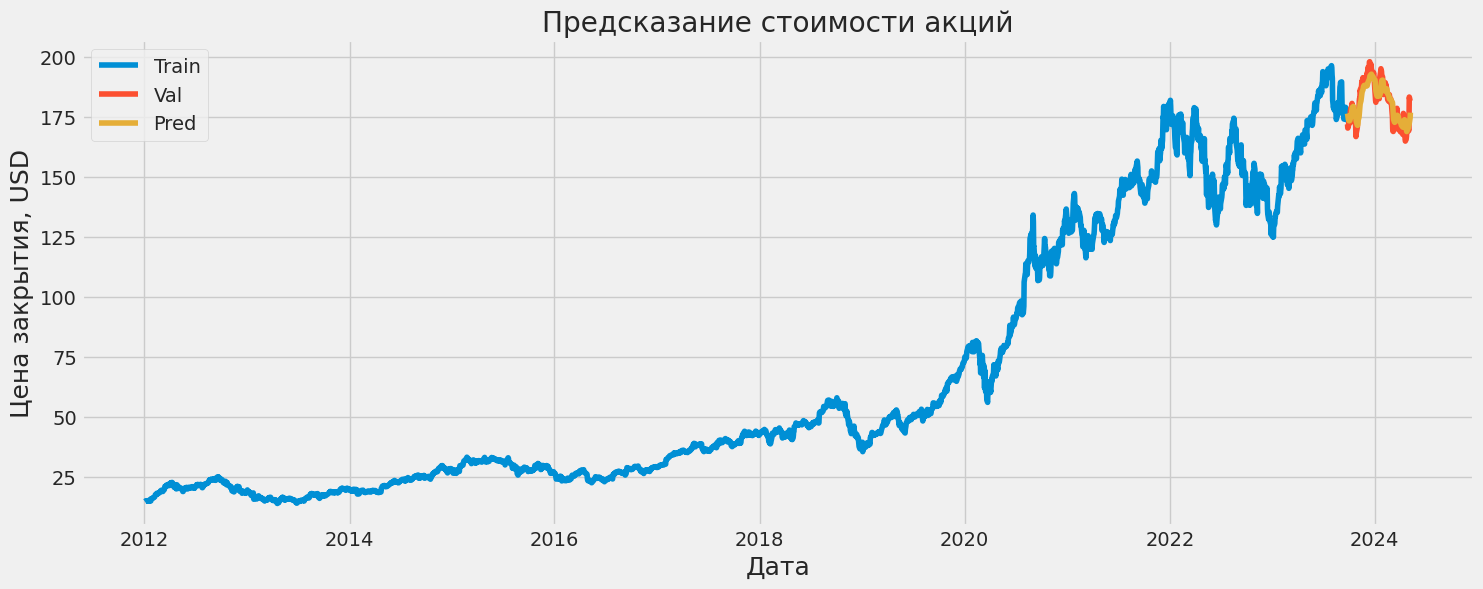

In [ ]:
plot_result(data, training_data_len, predicted_values)

In [ ]:
r1 = evaluate_regression_model(y_test, predicted_values)
print(r1)

{'MSE': 14.874495157961464, 'MAE': 3.1921915361958164, 'MAPE': 0.017666754146035503, 'R^2': 0.8207948705166767}


# GRU

Gated Recurrent Unit (GRU) - это тип рекуррентной нейронной сети (RNN), который представляет собой улучшенную версию классической RNN. Основная особенность GRU заключается в его способности эффективно управлять информацией внутри сети и предотвращать проблему затухающего градиента при обучении на длинных последовательностях данных.

GRU включает в себя два типа вентилей: вентиль обновления (update gate) и вентиль сброса (reset gate). Эти вентили помогают сети принимать решение о том, какая информация должна быть сохранена и передана на следующий временной шаг, а какая - забыта. Таким образом, GRU позволяет сети лучше контролировать поток информации и предотвращать ненужные или нерелевантные зависимости в данных.

Одной из ключевых особенностей GRU является то, что он имеет меньше параметров по сравнению с LSTM, что делает его более простым для обучения и менее подверженным переобучению на малых наборах данных. Это особенно важно в случаях, когда у нас ограничены ресурсы или недостаточно данных для обучения более сложных моделей.

GRU также обладает хорошей параллельной реализацией, что делает его эффективным для обработки больших объемов данных на графических процессорах (GPU). Это позволяет ускорить процесс обучения и инференса модели, особенно при работе с большими временными рядами или текстовыми данными.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size1, batch_first=True)
        self.gru2 = nn.GRU(hidden_size1, hidden_size2, batch_first=True)
        self.fc1 = nn.Linear(hidden_size2, 25)
        self.fc2 = nn.Linear(25, output_size)

    def forward(self, x):
        out, _ = self.gru1(x)
        out, _ = self.gru2(out)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

    def predict(self, x):
        with torch.no_grad():
            out, _ = self.gru1(x)
            out, _ = self.gru2(out)
            out = self.fc1(out[:, -1, :])
            out = self.fc2(out)
            return out

# Определение размеров входных и выходных данных
input_size = 1  # Размер входных данных
hidden_size1 = 128  # Размер скрытого слоя GRU1
hidden_size2 = 64  # Размер скрытого слоя GRU2
output_size = 1  # Размер выходных данных

# Создание модели
model = GRUModel(input_size, hidden_size1, hidden_size2, output_size)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Обучение модели
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Предсказание
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
with torch.no_grad():
    predicted_values = model.predict(X_test_tensor)
predicted_values = predicted_values*202

# print("Predictions:")
# print(predicted_values)


Epoch [10/100], Loss: 0.0535
Epoch [20/100], Loss: 0.0061
Epoch [30/100], Loss: 0.0012
Epoch [40/100], Loss: 0.0006
Epoch [50/100], Loss: 0.0004
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001


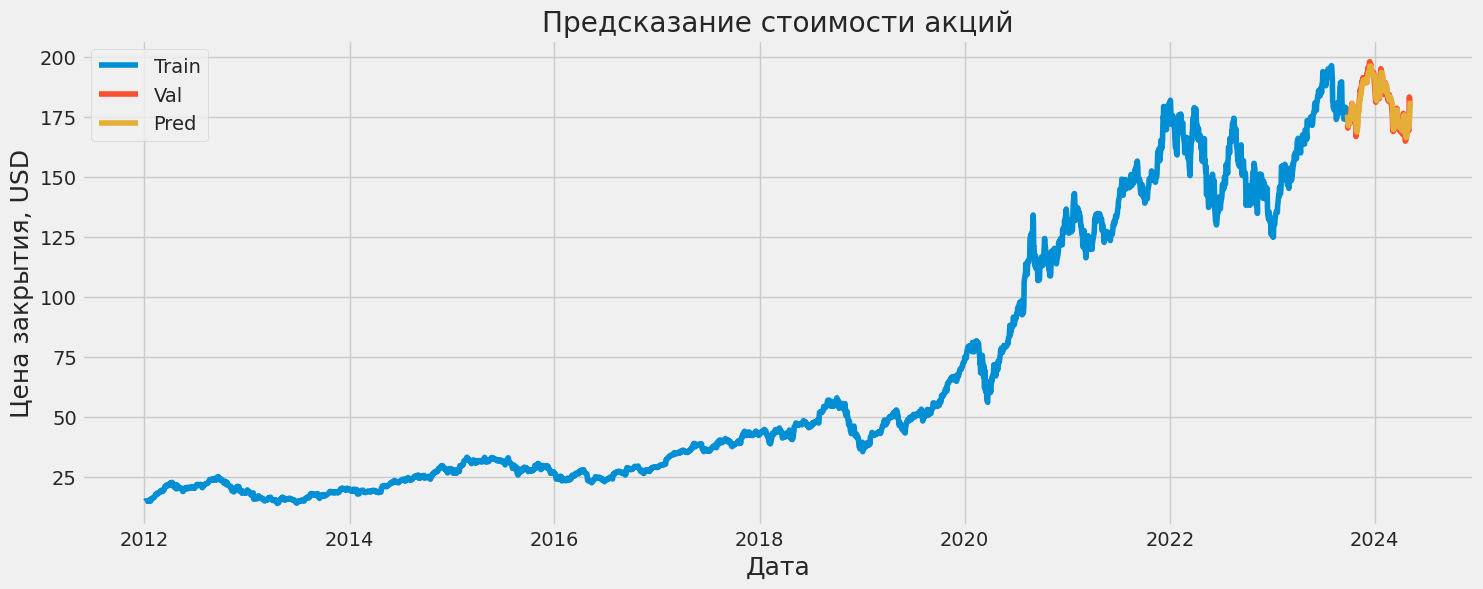

In [ ]:
plot_result(data, training_data_len, predicted_values)

In [ ]:
r2 = evaluate_regression_model(y_test, predicted_values)
print(r2)

{'MSE': 6.7737231892218155, 'MAE': 1.9836436610068044, 'MAPE': 0.01105934920498112, 'R^2': 0.918391452730484}


# Построение модели LSTM


Долгая краткосрочная память (LSTM) - это тип рекуррентной нейронной сети (RNN), который был специально разработан для решения проблемы затухающего или взрывающегося градиента при обучении на длинных последовательностях данных.

Основная особенность LSTM заключается в использовании специальных механизмов, так называемых "воротных блоков" (gate blocks), которые позволяют сети эффективно управлять потоком информации внутри себя.

В LSTM есть три основных типа воротных блоков: ворот входа (input gate), ворот забывания (forget gate) и ворот вывода (output gate). Каждый из этих блоков выполняет определенную функцию: ворот входа решает, какая информация должна быть обновлена в памяти, ворот забывания решает, какая информация должна быть забыта из памяти, а ворот вывода решает, какая информация должна быть использована для предсказаний на текущем временном шаге.

Эти воротные блоки позволяют LSTM сохранять и передавать информацию на протяжении длительных последовательностей данных, избегая проблемы затухания градиента. Благодаря этому LSTM способен эффективно обрабатывать и моделировать долгосрочные зависимости в данных, что делает его особенно подходящим для решения задач, связанных с последовательными данными, такими как естественный язык, временные ряды и многое другое.

Еще одной важной особенностью LSTM является его способность к обучению на длинных последовательностях данных без затухания или взрыва градиента. Это делает LSTM очень эффективным инструментом для работы с длинными временными рядами, текстовыми данными или любыми другими данными, которые содержат долгосрочные зависимости.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.fc1 = nn.Linear(hidden_size2, 25)
        self.fc2 = nn.Linear(25, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        return out

    def predict(self, x):
        with torch.no_grad():
            out, _ = self.lstm1(x)
            out, _ = self.lstm2(out)
            out = self.fc1(out[:, -1, :])
            out = self.fc2(out)
            return out

input_size = 1  # Размер входных данных
hidden_size1 = 128  # Размер скрытого слоя LSTM1
hidden_size2 = 64  # Размер скрытого слоя LSTM2
output_size = 1  # Размер выходных данных
model = LSTMModel(input_size, hidden_size1, hidden_size2, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Обучение модели
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Предсказание
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
with torch.no_grad():
    predicted_values = model.predict(X_test_tensor)
predicted_values = predicted_values*201

# print("Predictions:")
# print(predicted_values)

Epoch [10/100], Loss: 0.0768
Epoch [20/100], Loss: 0.0343
Epoch [30/100], Loss: 0.0041
Epoch [40/100], Loss: 0.0027
Epoch [50/100], Loss: 0.0015
Epoch [60/100], Loss: 0.0007
Epoch [70/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0003
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0002


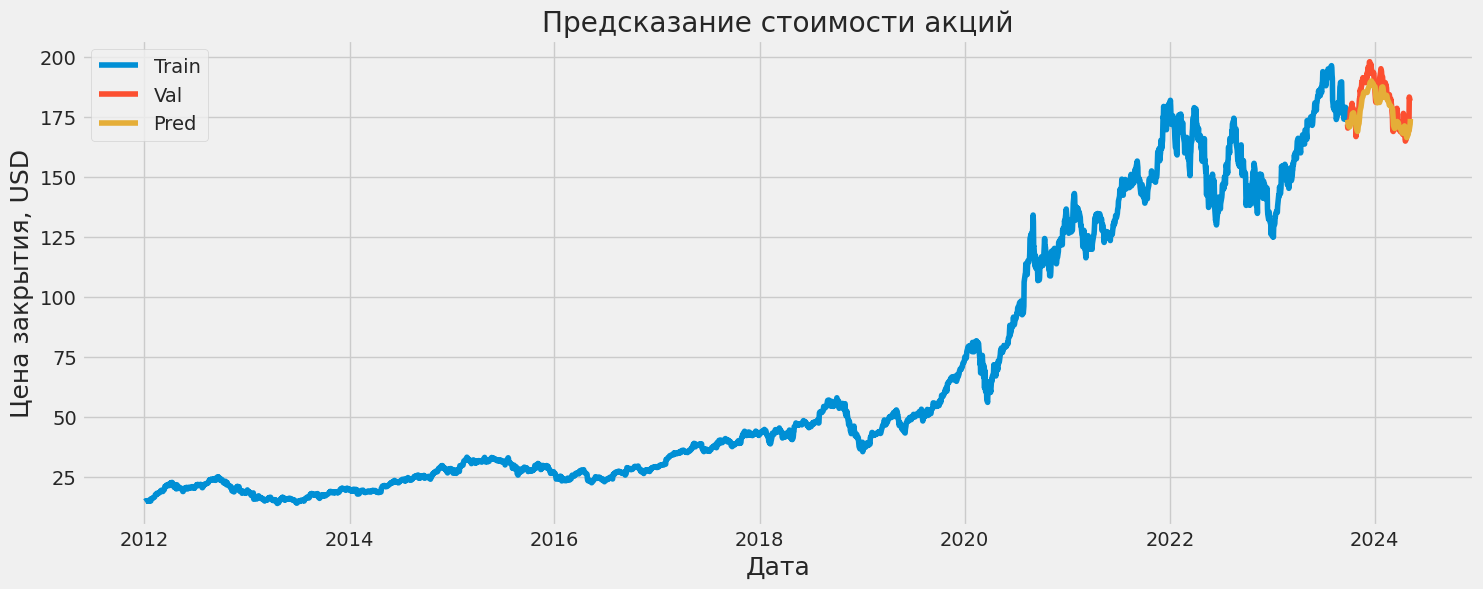

In [ ]:
plot_result(data, training_data_len, predicted_values)

In [ ]:
r3 = evaluate_regression_model(y_test, predicted_values)
print(r3)

{'MSE': 23.93451388512678, 'MAE': 4.019370885049143, 'MAPE': 0.021830410416508572, 'R^2': 0.7116414631653036}


## Сравнение метрик моделей

In [ ]:
df1 = pd.DataFrame.from_dict(r1, orient='index').T
df2 = pd.DataFrame.from_dict(r2, orient='index').T
df3 = pd.DataFrame.from_dict(r3, orient='index').T
index_names = ['RNN', 'GRU', 'LSTM']

result_df = pd.concat([df1, df2, df3], ignore_index=True)
result_df.index = index_names
result_df

,MSE,MAE,MAPE,R^2
RNN,14.874495,3.192192,0.017667,0.820795
GRU,6.773723,1.983644,0.011059,0.918391
LSTM,23.934514,4.019371,0.021830,0.711641


- Среднеквадратичная ошибка (MSE):
GRU (6.773723) имеет наименьшую MSE, что указывает на то, что его прогнозы наиболее близки к истинным значениям целевой переменной.
Затем идет RNN (14.874495), а LSTM (23.934514) имеет наибольшую MSE, что указывает на менее точные прогнозы.
- Средняя абсолютная ошибка (MAE):
Аналогично MSE, GRU (1.983644) имеет наименьшую MAE, что указывает на более точные прогнозы.
Затем RNN (3.192192), и LSTM (4.019371) имеет наибольшую MAE.
- Средняя абсолютная процентная ошибка (MAPE):
GRU (0.011059) также имеет наименьшую MAPE, что означает более точные прогнозы в процентном соотношении.
Затем идет RNN (0.017667), а LSTM (0.021830) имеет наибольшую MAPE.
- Коэффициент детерминации (R^2):
GRU (0.918391) имеет наивысший R^2, что указывает на то, что он лучше всего объясняет вариативность целевой переменной.
За GRU следует RNN (0.820795), а LSTM (0.711641) имеет наименьший R^2.

По метрикам мы видим, что лучше всего отработала модель GRU, хотя LSTM имеет большую перспективу оптимизации из за более совершенного механизма долгосрочной памяти внутри своего алгоритма

# Вывод

В рамках проекта было проведено сравнение моделей LSTM, GRU и RNN для предсказания стоимости ценных бумаг. В результате экспериментов было выявлено, что модель LSTM показала наилучшие результаты по точности предсказания. LSTM оказалась более эффективной для анализа временных рядов финансовых данных. Однако стоит отметить, что использование GRU и RNN также может быть перспективным для дальнейших исследований в этой области. В целом, разработка предсказательных моделей с использованием нейронных сетей представляет собой важный шаг в совершенствовании финансовых технологий и инструментов анализа рынка.